# Active Learning
Active learning is an iterative process where a model actively selects the most informative data points to be labeled by an oracle (e.g. a human expert), optimizing the model's performance with fewer labeled samples. Active learning can be implemented with Chemprop through Python as demonstrated by this notebook.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/active_learning.ipynb)

In [1]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

### Import packages

In [2]:
from pathlib import Path
import random
from typing import Tuple

from lightning import pytorch as pl
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader

from chemprop import data, featurizers, models, nn

### Load some data

In [3]:
chemprop_dir = Path.cwd().parent
input_path = (
    chemprop_dir / "tests" / "data" / "regression" / "mol" / "mol.csv"
)  # path to your data .csv file
df_input = pd.read_csv(input_path)
smis = df_input.loc[:, "smiles"].values
ys = df_input.loc[:, ["lipo"]].values
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

In this notebook we use three sets of data: An starting set of training data, a set of data to select additional training data from, and a set of data to test the model on. The set of data to select additional training data from could be unlabeled, but for this example all the data already has labels.

In [4]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
splitting_indices = data.make_split_indices(mols, "random", (0.1, 0.8, 0.1))
starting_data, additional_data, test_data = data.split_data_by_indices(all_data, *splitting_indices)
starting_data, additional_data, test_data = starting_data[0], additional_data[0], test_data[0]
test_loader = data.build_dataloader(data.MoleculeDataset(test_data), shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


During each iteration of active learning, the training data will be split into training and validation sets and packaged into data loaders, so we make a helper function to do this.

In [5]:
def get_dataloaders(trainval_data) -> Tuple[DataLoader]:
    trainval_mols = [d.mol for d in trainval_data]
    train_indices, _, val_indices = data.make_split_indices(
        trainval_mols, "random", (0.9, 0.0, 0.1)
    )
    train_data, val_data, _ = data.split_data_by_indices(
        trainval_data, train_indices, val_indices, None
    )

    train_dset = data.MoleculeDataset(train_data[0])
    scaler = train_dset.normalize_targets()

    val_dset = data.MoleculeDataset(val_data[0])
    val_dset.normalize_targets(scaler)

    train_loader = data.build_dataloader(train_dset)
    val_loader = data.build_dataloader(val_dset, shuffle=False)
    return train_loader, val_loader, scaler

We also define a helper function to construct a chemprop model. Because this is a regression task, the targets of the training data are normalized and the model needs the scaler that was used to unnormalize the predictions.

In [6]:
def get_mpnn(scaler):
    output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
    ffn = nn.MveFFN(output_transform=output_transform)
    mpnn = models.MPNN(nn.BondMessagePassing(), nn.MeanAggregation(), ffn, batch_norm=False)
    return mpnn

We also need a lightning trainer to run the model.

In [7]:
trainer = pl.Trainer(
    logger=False, enable_progress_bar=False, accelerator="cpu", devices=1, max_epochs=20
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


# Change active learning parameters here

A priority function (or acquistition function) guides the active learning process by selecting the most informative data points to label next. A good choice for such a function is the uncertainty of a model's output on each data point.

In [8]:
# rank datapoints based on priority, priority determined by variance
def priority_function(mpnn, datapoint):
    dataset = data.MoleculeDataset([datapoint])
    loader = data.build_dataloader(dataset, batch_size=1)
    output = trainer.predict(mpnn, loader)
    output = torch.concat(output, dim=0)
    return output[..., 1]

If our additional data was unlabeled, we would need a way to get the labels for the selected data points. 

In [9]:
# the oracle takes a list of potentially unlabeled datapoints to be labeled for the next active learning iteration.
def request_labels(new_data):
    # adding new data labels:
    # for datapoint in new_data:
    #     datapoint.y = {label}
    return

Lastly, we also need to decide how many data points to add to our training set in each iteration.

In [10]:
# number of new datapoints added to trainval pool each iteration.
query_size = len(additional_data) // 8

## Start training

We start by training a model on the initial training data.

In [11]:
train_loader, val_loader, scaler = get_dataloaders(starting_data)
mpnn = get_mpnn(scaler)
trainer.fit(mpnn, train_loader, val_loader)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
Dropping last batch of size 1 to avoid issues with batch normalization     (dataset size = 1, batch_size = 64)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
`Trainer.fit` stopped: `max_epochs=20` reached.


Now we can start the active learning loop. In each iteration, we train a model on the current training data, use the model to select the most informative data points (the ones where the model is least certain), add them to the training data, and repeat.

In [12]:
trainval_data = starting_data
results = []

for _ in range(len(additional_data) // query_size):
    # sort new datapoints by priority using priority function
    priority_remaining_data = [
        (priority_function(mpnn, datapoint), datapoint) for datapoint in additional_data
    ]
    sorted_remaining_data = [
        datapoint
        for unc, datapoint in sorted(priority_remaining_data, key=lambda d: d[0], reverse=True)
    ]

    new_data = sorted_remaining_data[:query_size]
    additional_data = additional_data[query_size:]

    request_labels(new_data)
    trainval_data.extend(new_data)

    train_loader, val_loader, scaler = get_dataloaders(trainval_data)

    mpnn = get_mpnn(scaler)
    trainer.fit(mpnn, train_loader, val_loader)

    result = trainer.test(mpnn, test_loader, weights_only=False)  # weights_only=False is only required with pytorch lightning version 2.6.0 or newer
    results.append((len(trainval_data), result[0]["test/mse"]))

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.1271133422851562     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │     1.399552345275879     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.2964231967926025     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.2283799648284912     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.1599222421646118     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.1098978519439697     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.1606972217559814     │
└───────────────────────────┴───────────────────────────┘

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:485: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jackson/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/jackson/minicon

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ message_passing │ BondMessagePassing │  227 K │ train │     0 │
│ 1 │ agg             │ MeanAggregation    │      0 │ train │     0 │
│ 2 │ bn              │ Identity           │      0 │ train │     0 │
│ 3 │ predictor       │ MveFFN             │ 90.9 K │ train │     0 │
│ 4 │ X_d_transform   │ Identity           │      0 │ train │     0 │
│ 5 │ metrics         │ ModuleList         │      0 │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 318 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.
/home/jackson/miniconda3/envs/chemprop_dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    1.2270450592041016     │
└───────────────────────────┴───────────────────────────┘

Finally we can view the results. The model's performance will hopefully improve with each iteration of active learning. Though this notebook is just an example. We didn't train the model for many epochs, and we used a very small dataset, so we don't expect to see the model improve. 

In [13]:
results

[(20, 1.1271133422851562),
 (30, 1.399552345275879),
 (40, 1.2964231967926025),
 (50, 1.2283799648284912),
 (60, 1.1599222421646118),
 (70, 1.1098978519439697),
 (80, 1.1606972217559814),
 (90, 1.2270450592041016)]

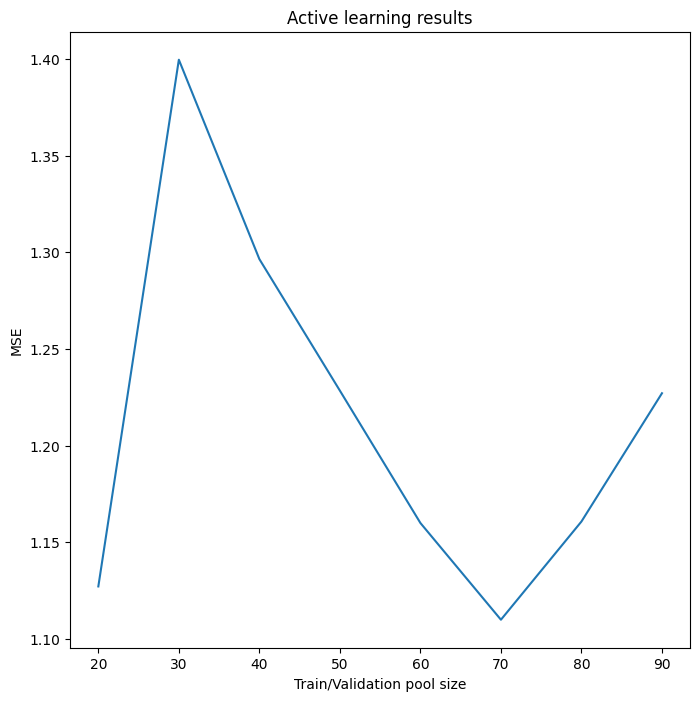

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Active learning results")
ax.set_xlabel("Train/Validation pool size")
ax.set_ylabel("MSE")

ax.plot([a[0] for a in results], [a[1] for a in results])
plt.show()